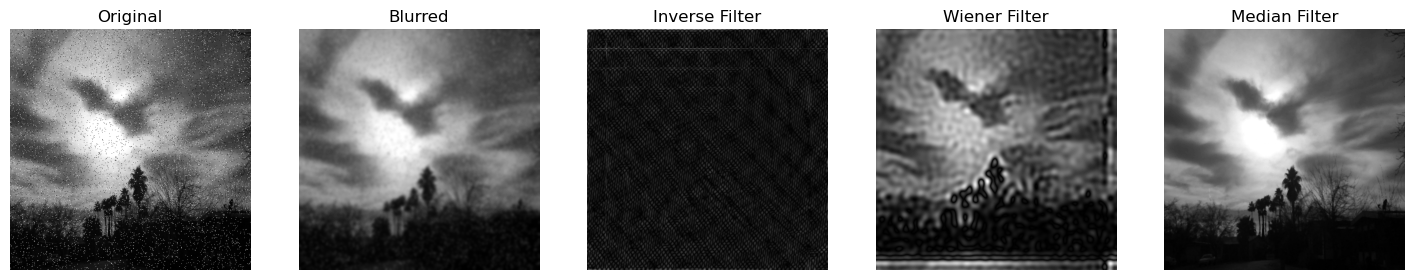

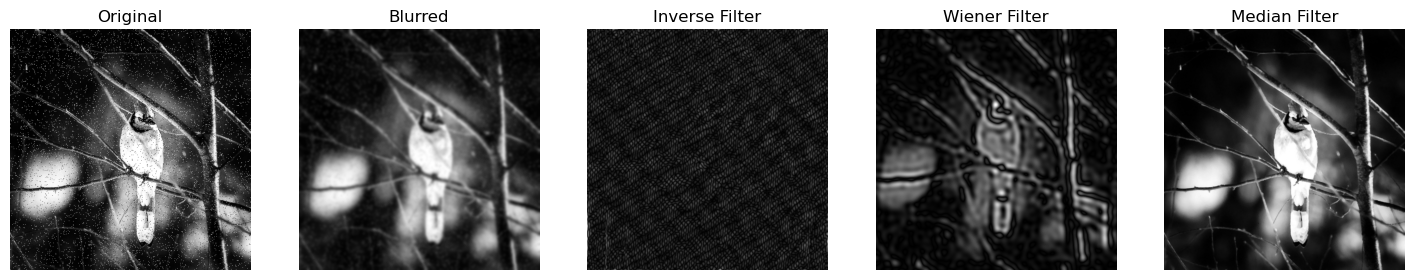

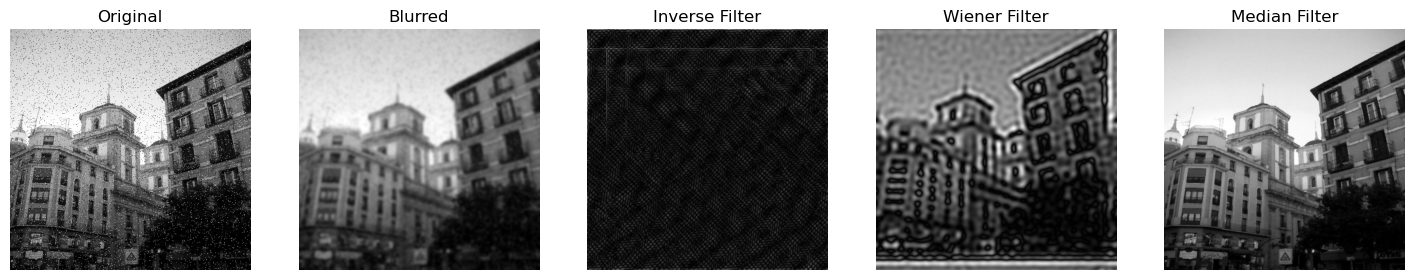

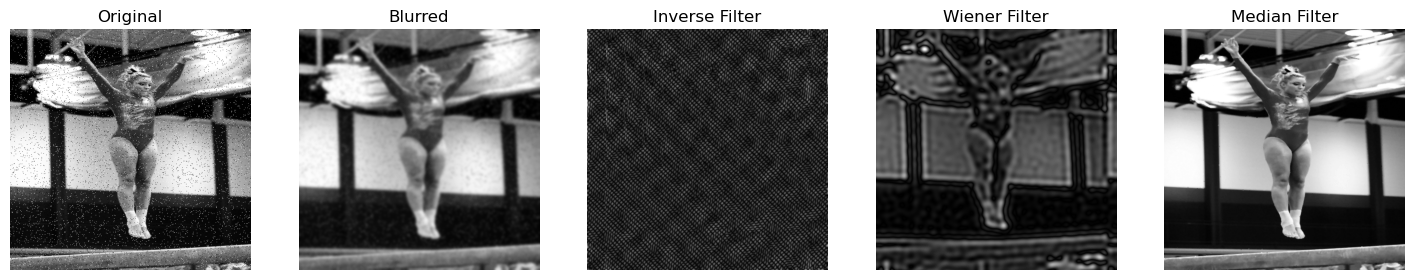

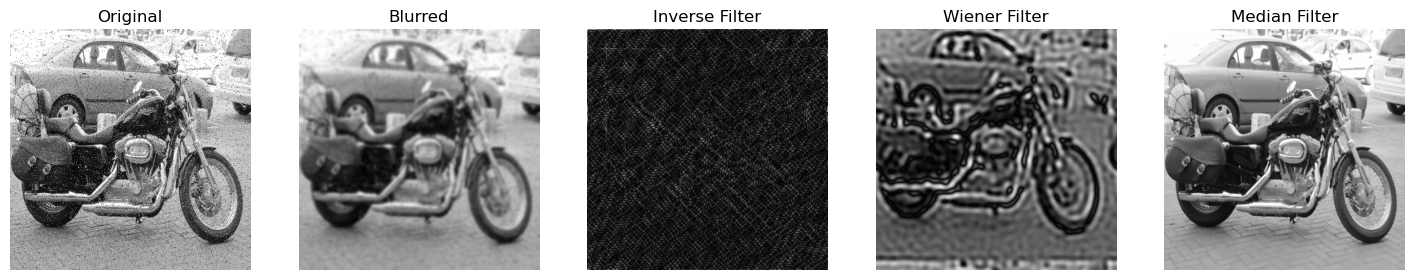

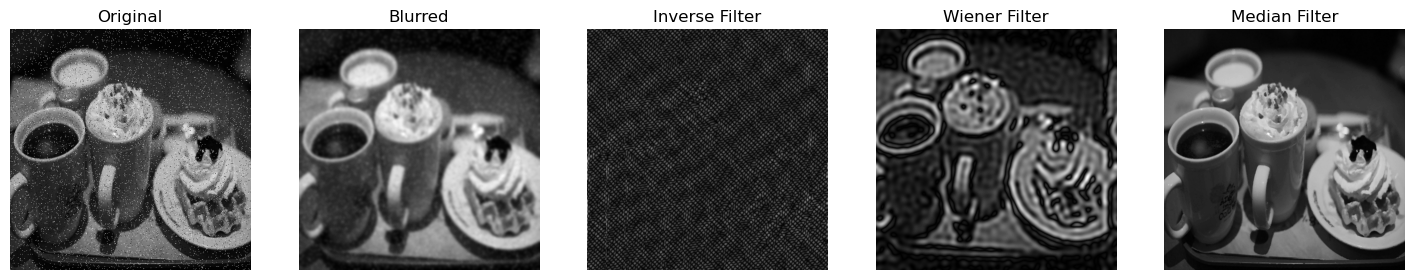

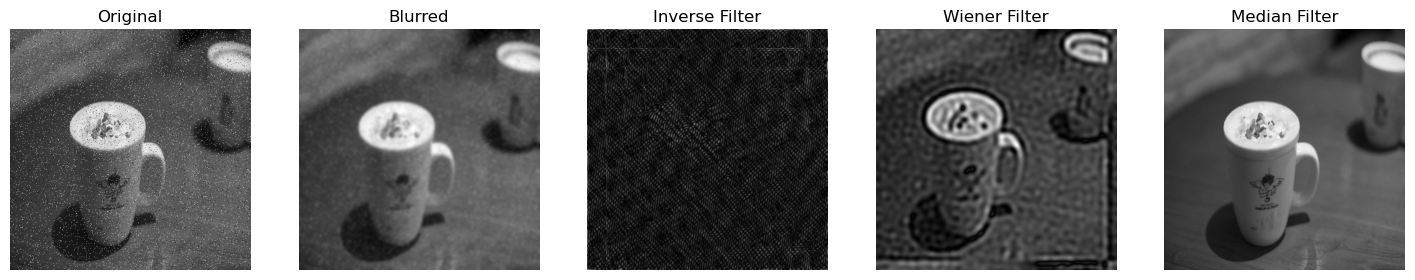

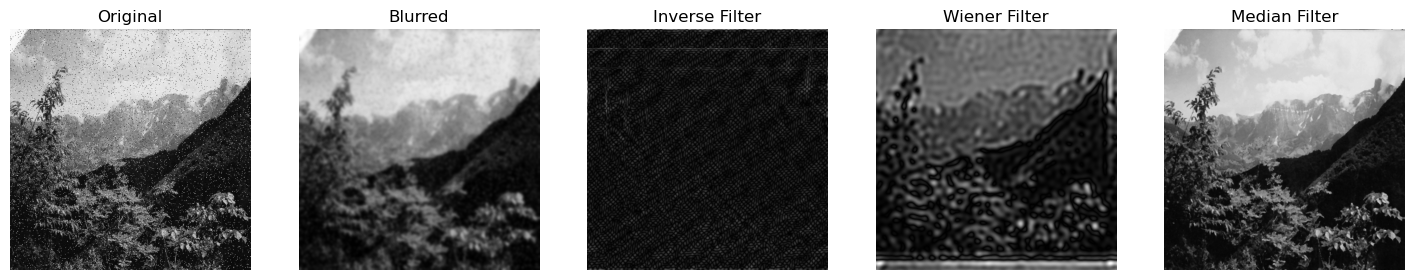

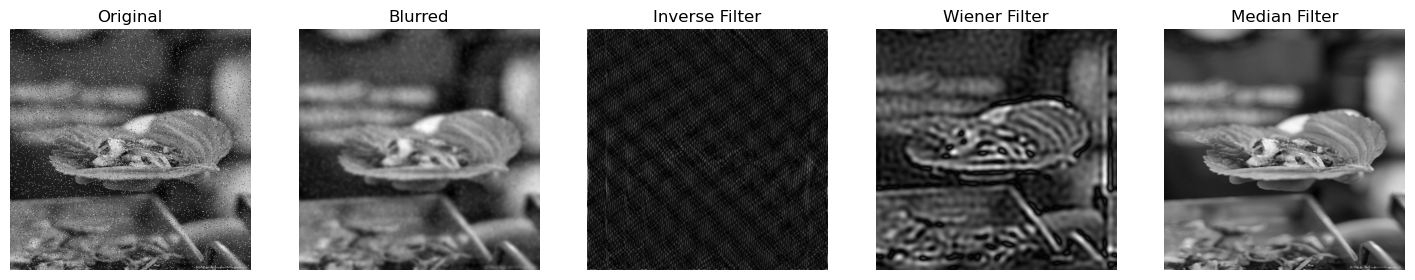

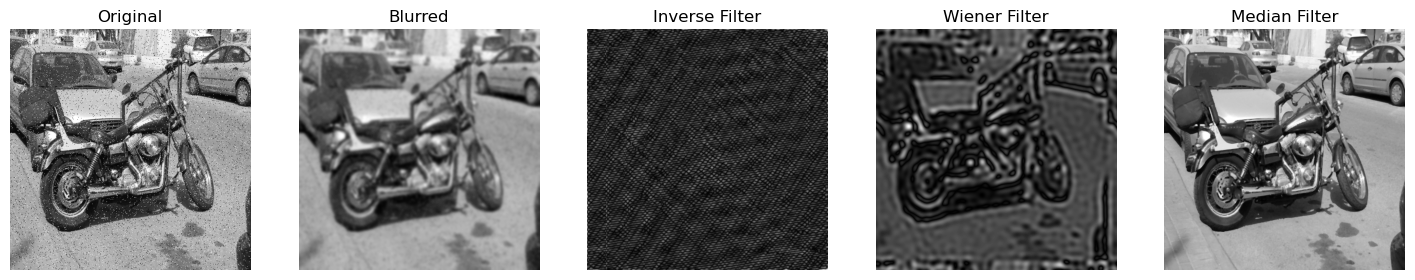

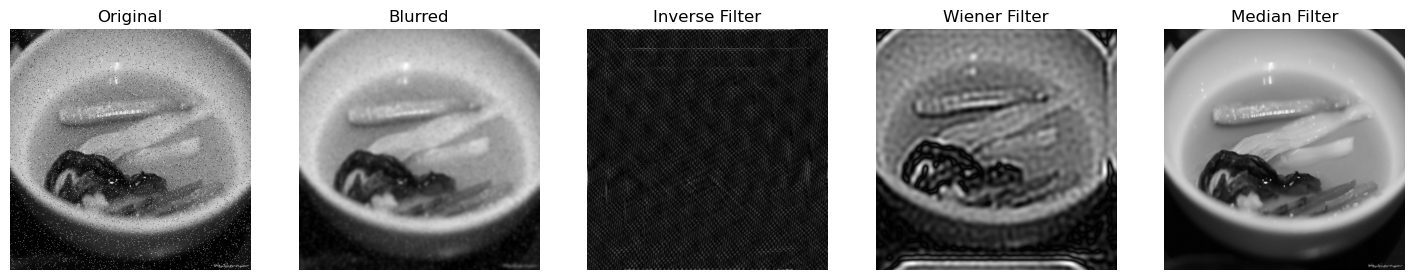

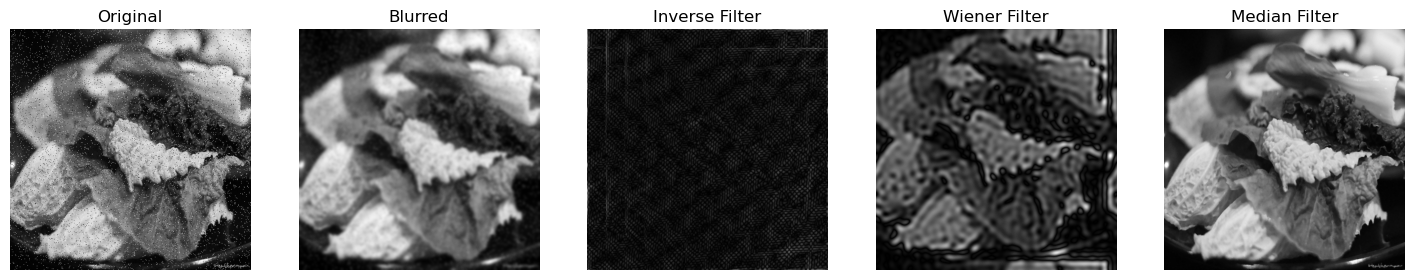

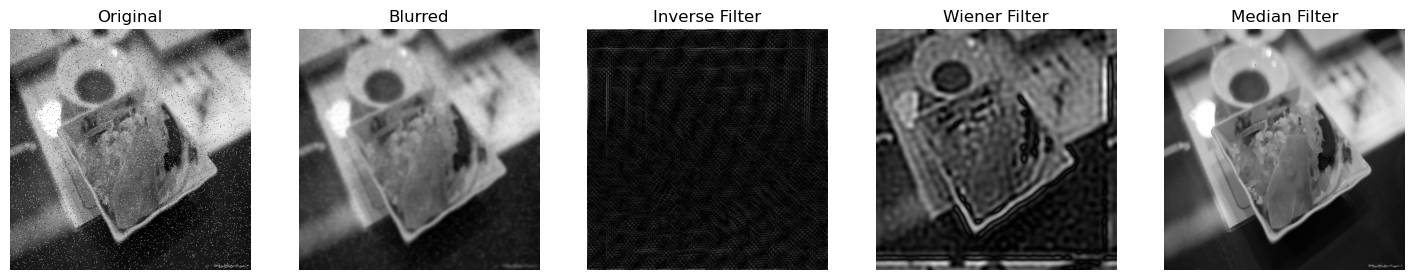

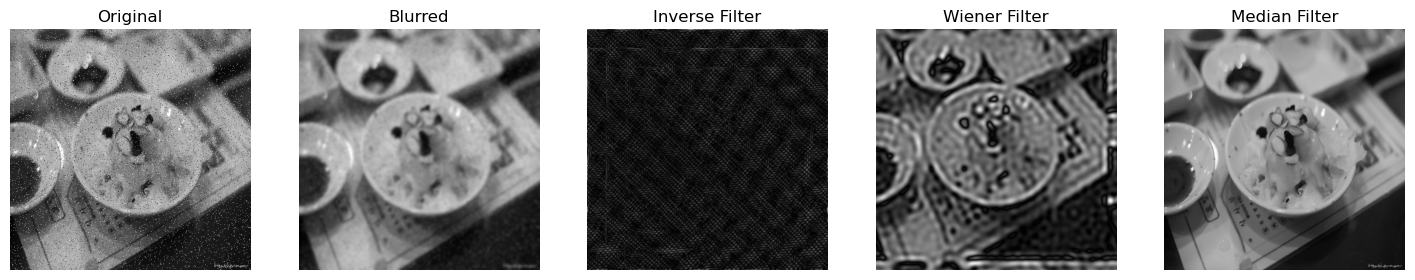

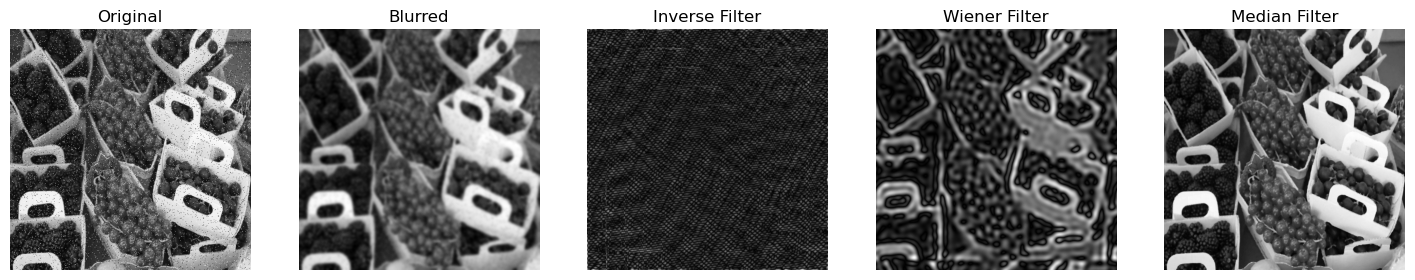

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

INPUT_DIR = r"C:\Users\jayja\Desktop\Noisy Images"  
OUTPUT_DIR = os.path.join(INPUT_DIR, "restored")   
os.makedirs(OUTPUT_DIR, exist_ok=True)           

K = 0.01             
BLUR_KERNEL = 15     
MEDIAN_KERNEL = 3   

def add_blur(img, ksize=7):
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

def psf_gaussian(size=41, sigma=7):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-(xx**2 + yy**2)/(2*sigma**2))
    psf /= psf.sum()  # Normalize so that sum = 1
    return psf

def inverse_filter(img, psf, eps=1e-3):
    H = np.fft.fft2(psf, s=img.shape) 
    G = np.fft.fft2(img)               
    F = G / (H + eps)                  
    return np.abs(np.fft.ifft2(F))     

def wiener_filter(img, psf, K=0.01):
    H = np.fft.fft2(psf, s=img.shape)
    G = np.fft.fft2(img)
    H_conj = np.conj(H)
    F = (H_conj / (H*H_conj + K)) * G 
    return np.abs(np.fft.ifft2(F))

shown = 0 
for file in os.listdir(INPUT_DIR):
    path = os.path.join(INPUT_DIR, file)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
    if img is None:
        continue 

    blurred = add_blur(img, BLUR_KERNEL)

    psf = psf_gaussian(size=41, sigma=7)
    inv_restored = inverse_filter(blurred, psf)
    wiener_restored = wiener_filter(blurred, psf, K)

    median_restored = cv2.medianBlur(img, MEDIAN_KERNEL)

    base, ext = os.path.splitext(file)
    cv2.imwrite(os.path.join(OUTPUT_DIR, base + "_blurred" + ext), blurred)
    cv2.imwrite(os.path.join(OUTPUT_DIR, base + "_inverse" + ext), inv_restored)
    cv2.imwrite(os.path.join(OUTPUT_DIR, base + "_wiener" + ext), wiener_restored)
    cv2.imwrite(os.path.join(OUTPUT_DIR, base + "_median" + ext), median_restored)

    if shown < 15:
        plt.figure(figsize=(18,4))
        plt.subplot(1,5,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
        plt.subplot(1,5,2); plt.imshow(blurred, cmap='gray'); plt.title("Blurred"); plt.axis('off')
        plt.subplot(1,5,3); plt.imshow(inv_restored, cmap='gray'); plt.title("Inverse Filter"); plt.axis('off')
        plt.subplot(1,5,4); plt.imshow(wiener_restored, cmap='gray'); plt.title("Wiener Filter"); plt.axis('off')
        plt.subplot(1,5,5); plt.imshow(median_restored, cmap='gray'); plt.title("Median Filter"); plt.axis('off')
        plt.show()
        shown += 1
